<a href="https://colab.research.google.com/github/Wayne122/CMPE257/blob/main/distillations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CMPE257 - Distillations

## Requests/Intent

## Team Blastoff

Han-Wei Lin

Sheetal Narvekar

Roger Navarro

Dataset: http://www.thetrumparchive.com/



### Take a look at the data

In [ ]:
import pandas as pd
df_tweets = pd.read_csv('tweets_10-17-2020.csv')
df_tweets.tail()

,id,text,isRetweet,device,favorites,retweets,date
54185,1212166009446162432,RT @heatherjones333: MAGNIFICENT TRUMP- KEEPIN...,t,Twitter for iPhone,0,7171,2020-01-01 12:17:52
54186,1212165377477750786,RT @heatherjones333: 🔥🔥🔥🔥🔥Lindsey Graham: Trum...,t,Twitter for iPhone,0,7393,2020-01-01 12:15:21
54187,1212165225748803585,RT @heatherjones333: Congratulations Sleepy Jo...,t,Twitter for iPhone,0,7953,2020-01-01 12:14:45
54188,1212165147902578688,RT @heatherjones333: DEAR STUPID PEOPLE- PEACE...,t,Twitter for iPhone,0,8963,2020-01-01 12:14:26
54189,1212165019053494272,RT @heatherjones333: 'We Have Taken Appropriat...,t,Twitter for iPhone,0,5948,2020-01-01 12:13:56


### Import stopwords from nltk

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Import packages needed and preprocess the data

In [ ]:
from nltk.corpus import stopwords

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
from gensim.models import CoherenceModel
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from datetime import datetime
import pandas as pd
import re
import math

In [ ]:
def clean_tweets(df=df_tweets, 
                 tweet_col='text', 
                 date_col='date',
                 start_datetime=datetime(2017,1,20, 0, 0, 0)
                ):
    
    df_copy = df.copy()
    
    # drop rows with empty values
    df_copy.dropna(inplace=True)
    
    # format the date
    df_copy[date_col] = df_copy[date_col].apply(lambda row: datetime.strptime(row, '%Y-%m-%d %H:%M:%S'))
    
    # filter rows older than a given date
    df_copy = df_copy[df_copy[date_col] >=start_datetime]
    
    # lower the tweets
    df_copy['preprocessed_' + tweet_col] = df_copy[tweet_col].str.lower()
    
    # filter out stop words and URLs
    en_stop_words = set(stopwords.words('english'))
    extended_stop_words = en_stop_words | \
                        {
                            '&amp;', 'rt', '@realdonaldtrump', 'realdonaldtrump', # adding @realdonaldtrump to the list
                            'th','co', 're', 've', 'kim', 'daca'
                        }
    url_re = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'        
    df_copy['preprocessed_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: ' '.join([word for word in row.split() if (word not in extended_stop_words) and (not re.match(url_re, word))]))
    
    # tokenize the tweets
    tokenizer = RegexpTokenizer('[a-zA-Z]\w+\'?\w*')
    df_copy['tokenized_' + tweet_col] = df_copy['preprocessed_' + tweet_col].apply(lambda row: tokenizer.tokenize(row))
    
    return df_copy


df_tweets = pd.read_csv('tweets_10-17-2020.csv')
df_tweets = df_tweets[df_tweets.isRetweet=='f']  # Exclude retweets
df_tweets_clean = clean_tweets(df_tweets)
df_tweets_clean.head()

,id,text,isRetweet,device,favorites,retweets,date,preprocessed_text,tokenized_text
5,1243755076214231040,"Such Fake reporting by the @nytimes, @washingt...",f,Twitter for iPhone,141942,34544,2020-03-28 04:21:32,"fake reporting @nytimes, @washingtonpost, @cnn...","[fake, reporting, nytimes, washingtonpost, cnn..."
6,1270411061376815108,My decision to appoint @usairforce General Cha...,f,Twitter for iPhone,157337,37398,2020-06-09 17:42:54,decision appoint @usairforce general charles b...,"[decision, appoint, usairforce, general, charl..."
9,1304767518775611394,....It has now been determined that the Muelle...,f,Twitter for iPhone,99088,26890,2020-09-12 13:03:12,....it determined mueller scam never set first...,"[it, determined, mueller, scam, never, set, fi..."
10,1304767518112964608,ALERT: So now we find out that the entire Muel...,f,Twitter for iPhone,166505,54049,2020-09-12 13:03:12,alert: find entire mueller “hit squad” illegal...,"[alert, find, entire, mueller, hit, squad, ill..."
11,1223351951963967488,"The Radical Left, Do Nothing Democrats keep ch...",f,Twitter for iPhone,183891,44015,2020-01-31 21:06:48,"radical left, nothing democrats keep chanting ...","[radical, left, nothing, democrats, keep, chan..."


### See the words that appears the most (Optional)

In [ ]:
def get_most_freq_words(str, n=None):
    vect = CountVectorizer().fit(str)
    bag_of_words = vect.transform(str)
    sum_words = bag_of_words.sum(axis=0)
    freq = [(word, sum_words[0, idx]) for word, idx in vect.vocabulary_.items()]
    freq =sorted(freq, key = lambda x: x[1], reverse=True)
    return freq[:n]
  
get_most_freq_words([ word for tweet in df_tweets_clean.tokenized_text for word in tweet],10)

[('great', 3360),
 ('amp', 1959),
 ('people', 1681),
 ('president', 1600),
 ('thank', 1352),
 ('democrats', 1275),
 ('news', 1269),
 ('trump', 1252),
 ('country', 1165),
 ('fake', 1129)]

### Find the best k for the topic number

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

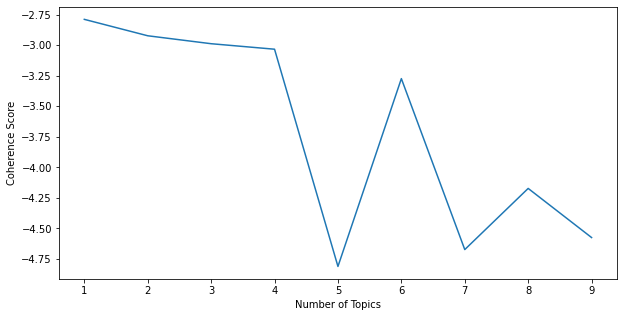

In [ ]:
# build a dictionary where for each tweet, each word has its own id.
tweets_dictionary = Dictionary(df_tweets_clean.tokenized_text)

# build the corpus i.e. vectors with the number of occurence of each word per tweet
tweets_corpus = [tweets_dictionary.doc2bow(tweet) for tweet in df_tweets_clean.tokenized_text]

# compute coherence
tweets_coherence = []
for nb_topics in range(1,10):
    lda = LdaModel(tweets_corpus, num_topics = nb_topics, id2word = tweets_dictionary, passes=10)
    cohm = CoherenceModel(model=lda, corpus=tweets_corpus, dictionary=tweets_dictionary, coherence='u_mass')
    coh = cohm.get_coherence()
    tweets_coherence.append(coh)

# visualize coherence
plt.figure(figsize=(10,5))
plt.plot(range(1,10),tweets_coherence)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

### Found k == 3, train the model and show the top words in each topic

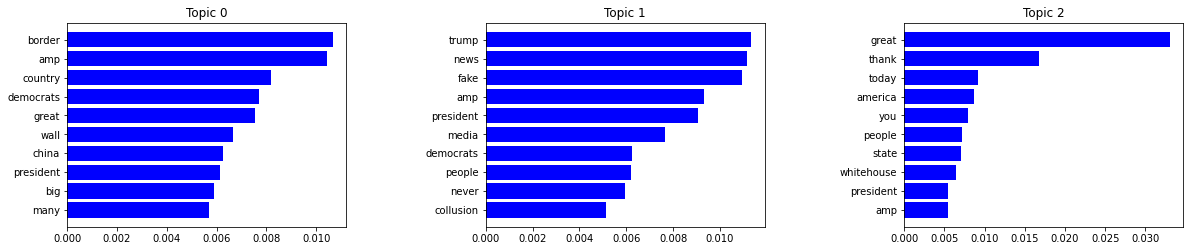

In [ ]:
k = 3
tweets_lda = LdaModel(tweets_corpus, num_topics = k, id2word = tweets_dictionary, passes=10)

def plot_top_words(lda=tweets_lda, nb_topics=k, nb_words=10):
    top_words = [[word for word,_ in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]
    top_betas = [[beta for _,beta in lda.show_topic(topic_id, topn=50)] for topic_id in range(lda.num_topics)]

    gs  = gridspec.GridSpec(round(math.sqrt(k))+1,round(math.sqrt(k))+1)
    gs.update(wspace=0.5, hspace=0.5)
    plt.figure(figsize=(20,15))
    for i in range(nb_topics):
        ax = plt.subplot(gs[i])
        plt.barh(range(nb_words), top_betas[i][:nb_words], align='center',color='blue', ecolor='black')
        ax.invert_yaxis()
        ax.set_yticks(range(nb_words))
        ax.set_yticklabels(top_words[i][:nb_words])
        plt.title("Topic "+str(i))
        
  
plot_top_words()

### Create a new dataframe for outputting the data with intents

In [ ]:
new_df = df_tweets_clean.drop(['preprocessed_text', 'tokenized_text'], axis=1)

### Predict intent of each tweet

In [ ]:
intents = []
tpv = tweets_lda[tweets_corpus]
for tweet in tpv:
    t0p = 0
    t1p = 0
    t2p = 0
    for topic in tweet:
        if topic[0] == 0:
            t0p = topic[1]
        if topic[0] == 1:
            t1p = topic[1]
        if topic[0] == 2:
            t2p = topic[1]
    mp = max(t0p, t1p, t2p)
    # Topics here are defined according to the top words in each topic
    if t0p == mp:
        intents.append("Diplomacy")
    elif t1p == mp:
        intents.append("News report")
    elif t2p == mp:
        intents.append("Appreciation")

Add the intent back to the original data

In [ ]:
new_df['intent'] = intents
new_df.head()

,id,text,isRetweet,device,favorites,retweets,date,intent
5,1243755076214231040,"Such Fake reporting by the @nytimes, @washingt...",f,Twitter for iPhone,141942,34544,2020-03-28 04:21:32,News report
6,1270411061376815108,My decision to appoint @usairforce General Cha...,f,Twitter for iPhone,157337,37398,2020-06-09 17:42:54,Appreciation
9,1304767518775611394,....It has now been determined that the Muelle...,f,Twitter for iPhone,99088,26890,2020-09-12 13:03:12,News report
10,1304767518112964608,ALERT: So now we find out that the entire Muel...,f,Twitter for iPhone,166505,54049,2020-09-12 13:03:12,News report
11,1223351951963967488,"The Radical Left, Do Nothing Democrats keep ch...",f,Twitter for iPhone,183891,44015,2020-01-31 21:06:48,News report


### Save the new dataset

In [ ]:
new_df.to_csv('tweets_10-17-2020-with-intents.csv', index=True)

### References:

https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-by-example-3b22cd10c835

https://stackoverflow.com/questions/16262016/how-to-predict-the-topic-of-a-new-query-using-a-trained-lda-model-using-gensim
